In [1]:
import pandas as pd
import wave
from scipy.signal import butter, filtfilt
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy.io.wavfile as wavfile
import librosa, librosa.display
import noisereduce as nr
from scipy.interpolate import interp1d
from matplotlib import mlab

/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
other = pd.read_csv('data_frames/ecoGuns_SST_Guns_Training-OtherSounds.csv')
ecoguns = pd.read_csv('data_frames/Guns_Training_ecoGuns_SST.csv')
pnn = pd.read_csv('data_frames/nn_Grid50_guns_dep1-7_Guns_Training.csv')

## Spectogram and time domain plots

In [3]:
def plot_freq_spectrum (origen_file, destination_file):
    wave_object = wave.open(origen_file, 'rb')
    channel = wave_object.getnchannels()
    n_samples = wave_object.getnframes()
    sample_freq = wave_object.getframerate()
    t_audio = n_samples/sample_freq
    signal_wave = wave_object.readframes(n_samples)
    if channel !=1:
        raise Exception ('Some sample have more than one channel')
    signal_array = np.frombuffer(signal_wave, dtype=np.int16)
    plt.figure(figsize=(19, 5))
    plt.specgram(signal_array, Fs=sample_freq, vmin=-20, vmax=50)
    #plt.specgram(signal_array, Fs=sample_freq, vmin=-70, vmax=0)
    plt.title('Spectogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.xlim(0, t_audio)
    plt.colorbar()
    #plt.savefig(destination_file)
    plt.show()

def plot_time (origen_file, destination_file):
    wave_object = wave.open(origen_file, 'rb')
    channel = wave_object.getnchannels()
    n_samples = wave_object.getnframes()
    sample_freq = wave_object.getframerate()
    t_audio = n_samples/sample_freq
    signal_wave = wave_object.readframes(n_samples)
    signal_array = np.frombuffer(signal_wave, dtype=np.int16)

    if channel !=1:
        raise Exception ('Some sample have more than one channel')
    times = np.linspace(0, t_audio, num = n_samples)
    plt.figure(figsize=(15, 5))
    plt.plot(times, signal_array)
    plt.title('Audio Wave')
    plt.ylabel('Signal Value')
    plt.xlabel('Time (s)')
    plt.xlim(0, t_audio)
    plt.grid()
    #plt.savefig(destination_file)
    plt.show()

## Joint plots

In [30]:
def joint_plots (origen_file, destination_file):
    # Load audio file and apply FFT
    sample_rate, samples = wavfile.read(origen_file)

    #samples = samples - samples.mean() # remove the mean 

    fft_values = np.fft.fft(samples)
    fig = plt.figure(figsize=(10, 12))

    # Plot time-domain representation of the audio signal
    ax1 = plt.subplot(311)
    t = np.arange(len(samples)) / float(sample_rate)
    ax1.plot(t, samples)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Time-domain representation')
    ax1.grid()

    # Plot frequency-domain representation of the audio signal: how much each frequency is contributing to overall sound of audio file
    ax2 = plt.subplot(312)
    ax2.plot(abs(fft_values))
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title('Magnitude spectrum plot: Contribution of each frequency')
    ax2.grid()

    # Plot spectrogram of the audio signal
    ax3 = plt.subplot(313)
    t_audio = len(samples)/sample_rate

    # Remove DC offset which is the presence of a non-zero mean value in the audio signal, and it can cause a large spike at 0 Hz in the spectrogram
    # This was done when mean was removed from samples 

    ax3.specgram(samples, Fs=sample_rate, vmin=-20, vmax=50)
    ax3.set_title('Spectogram')
    ax3.set_ylabel('Frequency (Hz)')
    ax3.set_xlabel('Time (s)')
    ax3.set_xlim(0, t_audio)

    # Combine all the plots into a single figure
    plt.tight_layout()
    #plt.savefig(destination_file)
    #plt.show()

[-2.16020287e+02 -9.80202874e+01  7.19797126e+01 ... -9.20202874e+01
 -2.02874049e-02  7.29797126e+01]


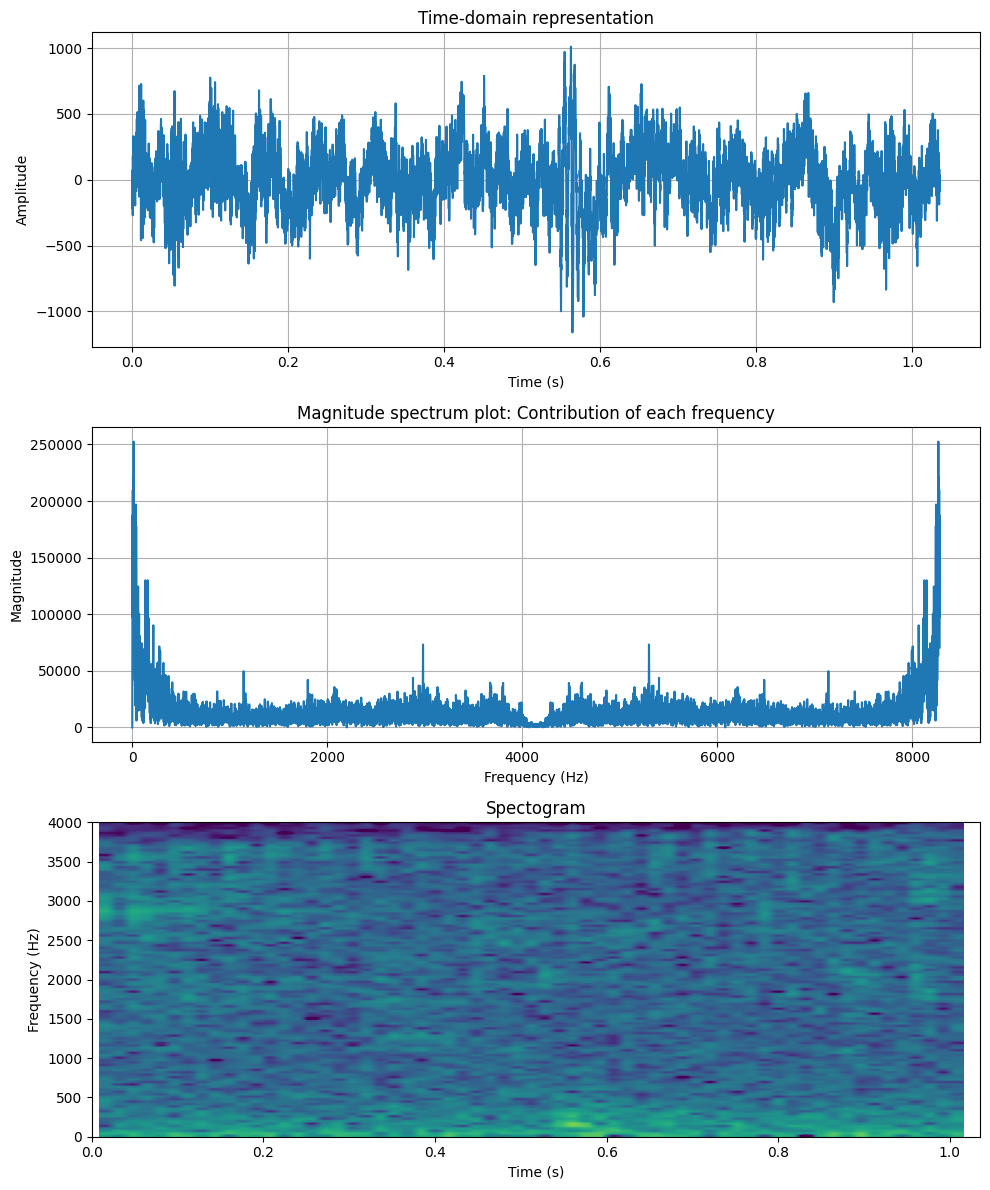

In [31]:
file_name = 'data/Clips/ecoguns1.wav' 
joint_plots(file_name,'whatever.png')

# Methods for Denoising/Filtering

## 1. Spectral gating
Allows a main signal to pass through only when it is above a set threshold: the gate is "open".
Works by computing a spectrogram of a signal and estimating a noise threshold (or gate) for each frequency band of that signal/noise. That threshold is used to compute a mask, which gates noise below the frequency-varying threshold.

Stationary Noise Reduction: Keeps the estimated noise threshold at the same level across the whole signal


https://pypi.org/project/noisereduce/


In [21]:
def denoise_spectal_gating(file_name, destination, stat, time_constant_s, thresh_n_mult_nonstationary):
    rate, data = wavfile.read(file_name)
    # data = data - data.mean() # remove mean 
    # perform noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=rate, stationary=stat) # time_constant_s = 0.1, thresh_n_mult_nonstationary = 2
   
    # saving the denoised sound
    #wavfile.write('data/Clips_denoised/' + destination, rate, reduced_noise)
    wavfile.write(destination, rate, reduced_noise)

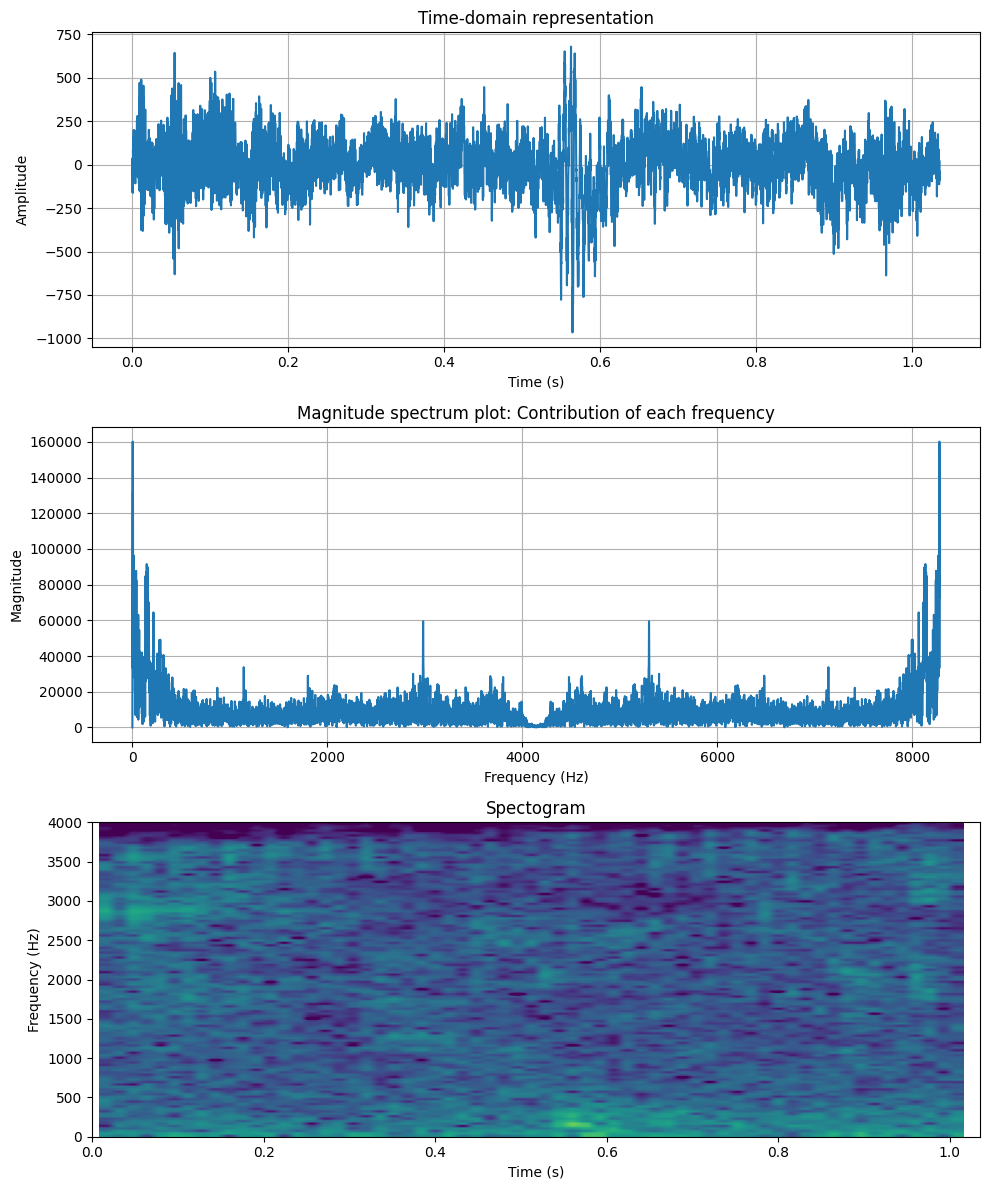

In [24]:
file_name = 'data/Clips/ecoguns1.wav' 
stat= False 
denoise_spectal_gating(file_name, 'test.wav', False, 0.1, 1)

joint_plots ('test.wav', 'whatever')


### Saving audio results for denoising from each category and saving the plots resulting from it

In [ ]:
for i in range(0,1095):
    # ECOGUNS
    file_name = ecoguns.iloc[i]['Clip Location']
    denoise_spectal_gating(file_name, f'gunshots/spectral_gating/ecoguns{i}.wav', True)
    file_name = f'data/Clips_denoised/gunshots/spectral_gating/ecoguns{i}.wav'
    destination1 = f'data/Images/denoised/gunshots/spectral_gating_individual_plot/ecoguns_freq{i}.png'
    destination2 = f'data/Images/denoised/gunshots/spectral_gating_individual_plot/ecoguns_time{i}.png'
    destination3 = f'data/Images/denoised/gunshots/spectral_gating_joint_plot/ecoguns{i}.png'
    #plot_freq_spectrum(file_name, destination1)
    #plot_time(file_name, destination2)
    joint_plots(file_name, destination3)

for i in range(0,59):
    # PNN
    file_name = pnn.iloc[i]['Clip Location']
    denoise_spectal_gating(file_name, f'gunshots/spectral_gating/pnn{i}.wav', True)
    file_name = f'data/Clips_denoised/gunshots/spectral_gating/pnn{i}.wav'
    destination1 = f'data/Images/denoised/gunshots/spectral_gating_individual_plot/pnn_freq{i}.png'
    destination2 = f'data/Images/denoised/gunshots/spectral_gating_individual_plot/pnn_freq{i}.png'
    destination3 = f'data/Images/denoised/gunshots/spectral_gating_joint_plot/pnn{i}.png'

    #plot_freq_spectrum(file_name, destination1)
    #plot_time(file_name, destination2)
    joint_plots(file_name, destination3)

for i in range(0,94):
    # OTHER
    file_name = other.iloc[i]['Clip Location']
    denoise_spectal_gating(file_name, f'no_gunshots/spectral_gating/other{i}.wav', True)
    file_name = f'data/Clips_denoised/no_gunshots/spectral_gating/other{i}.wav'
    destination1 = f'data/Images/denoised/no_gunshots/spectral_gating_individual_plot/other_freq{i}.png'
    destination2 = f'data/Images/denoised/no_gunshots/spectral_gating_individual_plot/other_time{i}.png'
    destination3 = f'data/Images/denoised/no_gunshots/spectral_gating_joint_plot/other{i}.png'
    #plot_freq_spectrum(file_name, destination1)
    #plot_time(file_name, destination2)
    joint_plots(file_name, destination3)


### Saving plot results for original sounds

In [ ]:
for i in range(0,20):
    # ECOGUNS
    file_name = f'data/Clips/ecoguns{i}.wav'
    destination = f'data/Images/original/gunshots/ecoguns{i}.png'
    joint_plots(file_name, destination)

for i in range(0,20):
    # PNN
    file_name = f'data/Clips/pnnn{i}.wav'
    destination = f'data/Images/original/gunshots/pnn{i}.png'
    joint_plots(file_name, destination)

for i in range(0,20):
    #OTHER
    file_name = f'data/Clips/other{i}.wav'
    destination = f'data/Images/original/no_gunshots/other{i}.png'
    joint_plots(file_name, destination)


## Low pass filtering
Low pass: allow only frequencies bellow a certain threshold to pass.

In [120]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff_freq, sample_rate, filter_order):
    b, a = butter_lowpass(cutoff_freq, sample_rate, filter_order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def low_pass_filter(cutoff_freq, origen_file, destination_file):
    # the cutoff freq is in Hz

    data, sample_rate = sf.read(origen_file)

    # Define filter parameters
    filter_order = 4

    # Apply low-pass filter
    filtered_data = apply_lowpass_filter(data, cutoff_freq, sample_rate, filter_order)

    # Save filtered audio
    sf.write(destination_file, filtered_data, sample_rate)


In [ ]:
# test
low_pass_filter(500, 'data/Clips_denoised/gunshots/spectral_gating/ecoguns0.wav', 'data/Clips_denoised/gunshots/low_pass/ecoguns0.wav')

#low_pass_filter(500, 'data/Clips_denoised/ecoguns0.wav', 'data/Clips_denoised/gunshots/low_pass/ecoguns0.wav')
joint_plots('data/Clips_denoised/gunshots/low_pass/ecoguns0.wav', 'whatever')

### Saving audios and images

In [ ]:
cutoff = 1000

for i in range(0,20):
    #ECOGUNS
    file_name = f'data/Clips_denoised/gunshots/spectral_gating/ecoguns{i}.wav'
    destination_file_audio = f'data/Clips_denoised/gunshots/low_pass/ecoguns{i}.wav'
    destination_file_image = f'data/Images/denoised/gunshots/low_pass_joint/ecoguns{i}.png'
    low_pass_filter(cutoff, file_name, destination_file_audio)
    joint_plots(destination_file_audio, destination_file_image)

    #PNN
    file_name = f'data/Clips_denoised/gunshots/spectral_gating/pnn{i}.wav'
    destination_file_audio = f'data/Clips_denoised/gunshots/low_pass/pnn{i}.wav'
    destination_file_image = f'data/Images/denoised/gunshots/low_pass_joint/pnn{i}.png'
    low_pass_filter(cutoff, file_name, destination_file_audio)
    joint_plots(destination_file_audio, destination_file_image)

    #OTHER: no gunshots
    file_name = f'data/Clips_denoised/no_gunshots/spectral_gating/other{i}.wav'
    destination_file_audio = f'data/Clips_denoised/no_gunshots/low_pass/other{i}.wav'
    destination_file_image = f'data/Images/denoised/no_gunshots/low_pass_joint/other{i}.png'
    low_pass_filter(cutoff, file_name, destination_file_audio)
    joint_plots(destination_file_audio, destination_file_image)



## Band-Pass Filter
Allows only frequencies withing a set range, for instance by making one from 1-500, we would remove signals from 0 to 1 HZ which would be trend. --> check how this looks

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def apply_bandpass_filter(data, lowcut_freq, highcut_freq, sample_rate, filter_order):
    b, a = butter_bandpass(lowcut_freq, highcut_freq, sample_rate, filter_order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


def band_pass_filter(lowcut_freq, highcut_freq, origen_file, destination_file):
    # the cutoff freqs are in Hz

    data, sample_rate = sf.read(origen_file)

    # Define filter parameters
    filter_order = 4

    # Apply bandpass filter
    filtered_data = apply_bandpass_filter(data, lowcut_freq, highcut_freq, sample_rate, filter_order)

    # Save filtered audio
    sf.write(destination_file, filtered_data, sample_rate)

/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


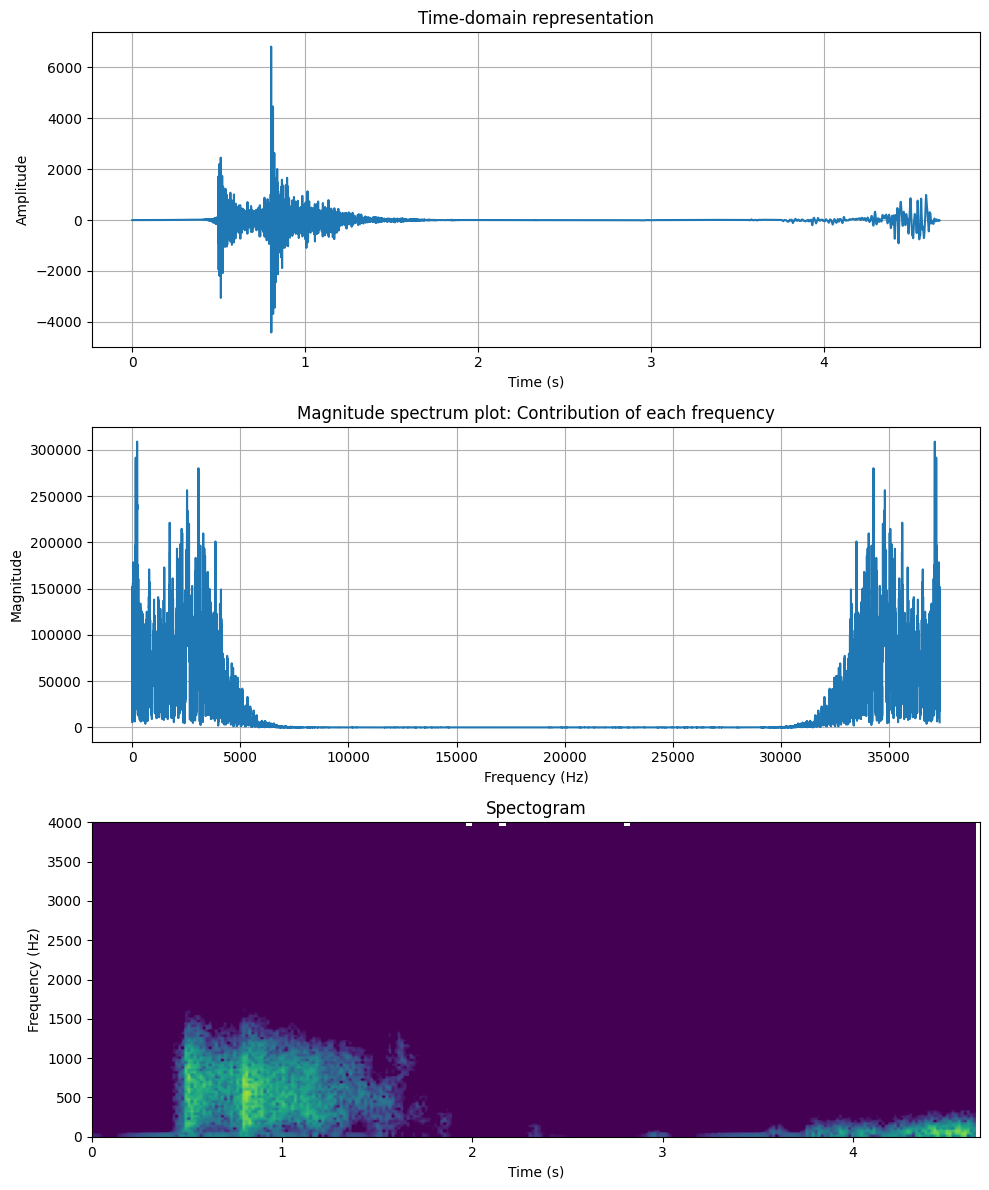

In [10]:
band_pass_filter(1, 1000, 'data/Clips_denoised/gunshots/spectral_gating/pnn37.wav', 'data/Clips_denoised/gunshots/band_pass/pnn37.wav')

#low_pass_filter(500, 'data/Clips_denoised/ecoguns0.wav', 'data/Clips_denoised/gunshots/low_pass/ecoguns0.wav')
joint_plots('data/Clips_denoised/gunshots/band_pass/pnn37.wav', 'whatever')

### Saving audio and images

In [ ]:
down = 50
up = 1000

for i in range(0,1095):
    #ECOGUNS
    file_name = f'data/Clips_denoised/gunshots/spectral_gating/ecoguns{i}.wav'
    destination_file_audio = f'data/Clips_denoised/gunshots/band_pass/ecoguns{i}.wav'
    destination_file_image = f'data/Images/denoised/gunshots/band_pass_joint/ecoguns{i}.png'
    band_pass_filter(down, up, file_name, destination_file_audio)
    joint_plots(destination_file_audio, destination_file_image)

for i in range(0,59):
    #PNN
    file_name = f'data/Clips_denoised/gunshots/spectral_gating/pnn{i}.wav'
    destination_file_audio = f'data/Clips_denoised/gunshots/band_pass/pnn{i}.wav'
    destination_file_image = f'data/Images/denoised/gunshots/band_pass_joint/pnn{i}.png'
    band_pass_filter(down, up, file_name, destination_file_audio)
    joint_plots(destination_file_audio, destination_file_image)

for i in range(0,94):
    #OTHER: no gunshots
    file_name = f'data/Clips_denoised/no_gunshots/spectral_gating/other{i}.wav'
    destination_file_audio = f'data/Clips_denoised/no_gunshots/band_pass/other{i}.wav'
    destination_file_image = f'data/Images/denoised/no_gunshots/band_pass_joint/other{i}.png'
    band_pass_filter(down, up, file_name, destination_file_audio)
    joint_plots(destination_file_audio, destination_file_image)


## Spectral Wightening

https://www.gw-openscience.org/GW150914data/GW150914_tutorial.html
